# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate
from transformers import AutoTokenizer, GPT2ForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, BitsAndBytesConfig, GPT2Tokenizer

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, precision_score,  recall_score, ConfusionMatrixDisplay

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import matplotlib.pyplot as plt


c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset and remove duplicate

In [2]:
data = pd.read_csv('ScamDataset.csv', delimiter=',', names=['message', 'label'])

original_shape = data.shape

# Removing duplicate rows
data = data.drop_duplicates()

# Shape after removing duplicates
new_shape = data.shape

original_shape, new_shape

((20670, 2), (15241, 2))

In [3]:
# Shuffle data to avoid any bias
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
data['label'] = data['label'].astype('category')
data['target'] = data['label'].cat.codes
data


,message,label,target
0,Important notice: Your account verification re...,fraud,0
1,"Poyyarikatur,kolathupalayam,unjalur post,erode...",normal,1
2,"Hi, my love! How goes that day? Fuck, this mor...",normal,1
3,Important notice: Your prize claim requires ur...,fraud,0
4,What are you doing later?,normal,1
...,...,...,...
15236,Ok no problem... Yup i'm going to sch at 4 if ...,normal,1
15237,Important notice: Your account verification re...,fraud,0
15238,Important notice: Your tax refund requires urg...,fraud,0
15239,Okay then. There are certain points you should...,normal,1


In [5]:
# Decode
data['label'].cat.categories
category_map = {code: category for code, category in enumerate(data['label'].cat.categories)}
category_map

{0: 'fraud', 1: 'normal'}

In [6]:
train_end_point = int(data.shape[0]*0.6)
val_end_point = int(data.shape[0]*0.8)
df_train = data.iloc[:train_end_point,:]
df_val = data.iloc[train_end_point:val_end_point,:]
df_test = data.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(9144, 3) (3049, 3) (3048, 3)


In [7]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

In [8]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [9]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'target'],
        num_rows: 9144
    })
    val: Dataset({
        features: ['message', 'target'],
        num_rows: 3048
    })
    test: Dataset({
        features: ['message', 'target'],
        num_rows: 3049
    })
})

In [10]:
dataset['train']

Dataset({
    features: ['message', 'target'],
    num_rows: 9144
})

In [11]:
df_train.target.value_counts(normalize=True)

target
0    0.542542
1    0.457458
Name: proportion, dtype: float64

In [12]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.4575, 0.5425])

In [13]:
model_name = "openai-community/gpt2"

In [14]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

In [15]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [16]:
model = GPT2ForSequenceClassification.from_pretrained(model_name,num_labels=2)
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [17]:
# model = prepare_model_for_kbit_training(model)
# model

In [18]:
# model = get_peft_model(model, lora_config)
# model

In [19]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name, add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [20]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1
model.to(torch.device("cuda"))

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [21]:
messages = df_test.message.tolist()
messages

['Important notice: Your account verification requires urgent attention. Act as soon as possible to avoid issues. Ref: 6583',
 'We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us',
 "Hi, I'm calling from a local Singaporean business. We're offering a discount on our services for new customers.",
 "second you receive this message, you need to leave your work aside so that we can discuss about your case and take necessary action on this matter in order to connect with officer. Press one and you will be connected to the concern department. If we don't hear from you, then we will be forced to take action against you. Press one and you will be connected to the concern C D P officer or press nine to disconnect the call. Hi, this is officer calling you from the customs and border protection. The very second you receive this message, you need to leave your work aside so that we can discuss about your case and take necessary action on this matter i

In [22]:
# Convert summaries to a list
messages = df_test.message.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(messages), batch_size):
    # Get the batch of sentences
    batch_messages = messages[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])

    print(batch_messages)

['Important notice: Your account verification requires urgent attention. Act as soon as possible to avoid issues. Ref: 6583', 'We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us', "Hi, I'm calling from a local Singaporean business. We're offering a discount on our services for new customers.", "second you receive this message, you need to leave your work aside so that we can discuss about your case and take necessary action on this matter in order to connect with officer. Press one and you will be connected to the concern department. If we don't hear from you, then we will be forced to take action against you. Press one and you will be connected to the concern C D P officer or press nine to disconnect the call. Hi, this is officer calling you from the customs and border protection. The very second you receive this message, you need to leave your work aside so that we can discuss about your case and take necessary action on this matter in o

In [23]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs


tensor([[  2.8061, -12.9165],
        [  3.1659, -12.0205],
        [  4.4655, -16.4768],
        ...,
        [  2.6427, -11.9333],
        [  4.9287, -15.4514],
        [  2.8825, -13.1532]], device='cuda:0')

In [24]:

final_outputs.argmax(axis=1)

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [25]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_16380\1915017267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


12192    0
12193    0
12194    0
12195    0
12196    0
        ..
15236    0
15237    0
15238    0
15239    0
15240    0
Name: predictions, Length: 3049, dtype: int64

In [26]:
df_test['predictions'].value_counts()

predictions
0    3048
1       1
Name: count, dtype: int64

In [27]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_16380\4293232383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


12192    fraud
12193    fraud
12194    fraud
12195    fraud
12196    fraud
         ...  
15236    fraud
15237    fraud
15238    fraud
15239    fraud
15240    fraud
Name: predictions, Length: 3049, dtype: object

In [28]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  y_test = y_test.astype('category')
  y_pred = y_pred.astype('category')

  y_test = y_test.cat.codes
  y_pred = y_pred.cat.codes

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

  # Plot confusion matrix
  labels = ['fraud', 'normal']
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix: {model_name}')
  plt.show()
  

# Results before fine tune

Accuracy: 0.5448
Precision: 1.0000
Recall: 0.0007
F1-Score: 0.0014
Confusion Matrix:
[[1660    0]
 [1388    1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.71      1660
           1       1.00      0.00      0.00      1389

    accuracy                           0.54      3049
   macro avg       0.77      0.50      0.35      3049
weighted avg       0.75      0.54      0.38      3049

Balanced Accuracy Score: 0.5003599712023038
Accuracy Score: 0.5447687766480813


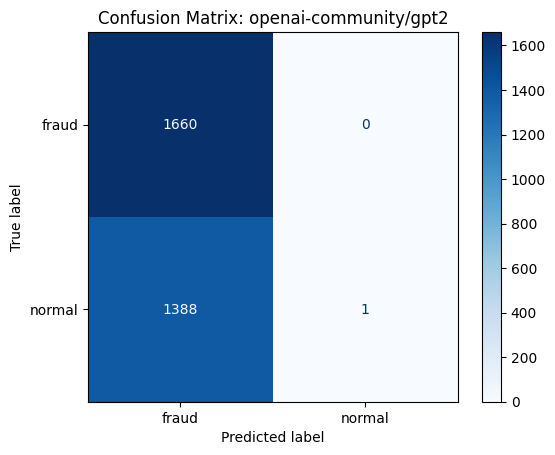

In [29]:
get_performance_metrics(df_test)

# Preprocess and tokenized data

In [30]:
MAX_LEN = 512
col_to_delete = ['message']

def preprocessing_function(examples):
    return tokenizer(examples['message'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map: 100%|██████████| 3049/3049 [00:00<00:00, 7528.39 examples/s]


In [31]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


In [32]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [33]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [34]:
training_args = TrainingArguments(
    output_dir = 'gpt_sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 3,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

In [35]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_16380\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


# Train model

In [36]:
train_result = trainer.train()

 15%|█▍        | 501/3429 [00:41<05:42,  8.54it/s]

{'loss': 0.1583, 'grad_norm': 0.0030406895093619823, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1001/3429 [01:29<03:03, 13.23it/s]

{'loss': 0.0669, 'grad_norm': 0.004335831850767136, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


                                                   
 33%|███▎      | 1143/3429 [01:48<02:47, 13.62it/s]

{'eval_loss': 0.04295603558421135, 'eval_balanced_accuracy': 0.990678178613969, 'eval_accuracy': 0.9914698162729659, 'eval_runtime': 6.8412, 'eval_samples_per_second': 445.533, 'eval_steps_per_second': 55.692, 'epoch': 1.0}


 44%|████▍     | 1502/3429 [02:18<02:21, 13.58it/s]

{'loss': 0.0306, 'grad_norm': 0.02801557630300522, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2002/3429 [02:57<01:56, 12.28it/s]

{'loss': 0.0267, 'grad_norm': 0.006466124206781387, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


                                                   
 67%|██████▋   | 2286/3429 [03:25<01:19, 14.36it/s]

{'eval_loss': 0.03027644194662571, 'eval_balanced_accuracy': 0.9932698704260174, 'eval_accuracy': 0.9934383202099738, 'eval_runtime': 6.4493, 'eval_samples_per_second': 472.612, 'eval_steps_per_second': 59.077, 'epoch': 2.0}


 73%|███████▎  | 2502/3429 [03:45<01:05, 14.12it/s]

{'loss': 0.0211, 'grad_norm': 0.008194878697395325, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3002/3429 [04:22<00:30, 13.88it/s]

{'loss': 0.0144, 'grad_norm': 0.002864914247766137, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


                                                   
100%|██████████| 3429/3429 [05:00<00:00, 13.38it/s]

{'eval_loss': 0.03965599462389946, 'eval_balanced_accuracy': 0.99393511348418, 'eval_accuracy': 0.9940944881889764, 'eval_runtime': 5.9832, 'eval_samples_per_second': 509.428, 'eval_steps_per_second': 63.679, 'epoch': 3.0}


100%|██████████| 3429/3429 [05:02<00:00, 11.34it/s]

{'train_runtime': 302.4503, 'train_samples_per_second': 90.699, 'train_steps_per_second': 11.337, 'train_loss': 0.047369415122449625, 'epoch': 3.0}


In [37]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  messages = df_test.message.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(messages), batch_size):
      # Get the batch of sentences
      batch_messages = messages[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
      
      print(batch_messages)

  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

['Important notice: Your account verification requires urgent attention. Act as soon as possible to avoid issues. Ref: 6583', 'We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us', "Hi, I'm calling from a local Singaporean business. We're offering a discount on our services for new customers.", "second you receive this message, you need to leave your work aside so that we can discuss about your case and take necessary action on this matter in order to connect with officer. Press one and you will be connected to the concern department. If we don't hear from you, then we will be forced to take action against you. Press one and you will be connected to the concern C D P officer or press nine to disconnect the call. Hi, this is officer calling you from the customs and border protection. The very second you receive this message, you need to leave your work aside so that we can discuss about your case and take necessary action on this matter in o

C:\Users\Potbottom\AppData\Local\Temp\ipykernel_16380\3895869390.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_16380\3895869390.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


Accuracy: 0.9934
Precision: 0.9949
Recall: 0.9906
F1-Score: 0.9928
Confusion Matrix:
[[1653    7]
 [  13 1376]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1660
           1       0.99      0.99      0.99      1389

    accuracy                           0.99      3049
   macro avg       0.99      0.99      0.99      3049
weighted avg       0.99      0.99      0.99      3049

Balanced Accuracy Score: 0.9932119406351106
Accuracy Score: 0.9934404722859954


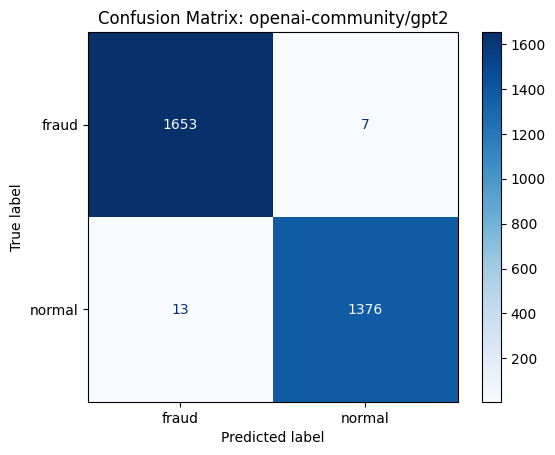

In [38]:
get_performance_metrics(df_test)

In [39]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        3.0
  total_flos               =   734815GF
  train_loss               =     0.0474
  train_runtime            = 0:05:02.45
  train_samples            =       9144
  train_samples_per_second =     90.699
  train_steps_per_second   =     11.337


In [42]:
trainer.save_model("./models/tuned_gpt_model")